In [2]:
using QuantumOptics
using DiffEqNoiseProcess
using PyPlot
using LaTeXStrings
using Random
using DelimitedFiles
using NPZ, Printf
using LinearAlgebra
using DifferentialEquations
using SpecialFunctions
using SparseArrays
using StatsBase
using Optim
using JLD2
using BenchmarkTools
include("HenryLib.jl")

make_white_noise (generic function with 1 method)

In [4]:
seed = Int(round(mod(time()*300,1000)))

280

In [8]:
num_runs = 15
Nspins = Int.(round.((10).^(LinRange(0.0, log(1000.0)/log(10.0), num_runs)))) 
# Int.((10).^(LinRange(0.0, 10000.0, num_runs)))
exc_times = zeros(num_runs)
avg_PN = zeros(num_runs)
std_PN = zeros(num_runs)
for i in range(1,num_runs)
    exc_times[i] = @elapsed tout, psi_t, W, fb, sb, bases, a, Sx, Sy, Sz = single_run(42, 1.0, Nspin=Nspins[i])
    avg_PN[i] = mean(real(expect(dagger(a)*a, psi_t)[2*div(length(tout), 3):length(tout)]))
    std_PN[i] = std(real(expect(dagger(a)*a, psi_t)[2*div(length(tout), 3):length(tout)]))
    jldsave("SizeScalingRslts.jld2"; Nspins, exc_times, avg_PN, std_PN)
end

Running with seed: 42Running with seed: 42Running with seed: 42Running with seed: 42Running with seed: 42Running with seed: 42Running with seed: 42Running with seed: 42Running with seed: 42Running with seed: 42Running with seed: 42Running with seed: 42Running with seed: 42Running with seed: 42Running with seed: 42

In [6]:
rslt = load("SizeScalingRslts.jld2")

Dict{String, Any} with 4 entries:
  "avg_PN"    => [0.000124902, 0.000134738, 0.000171366, 0.000220201, 0.0003545…
  "Nspins"    => [1, 2, 3, 4, 7, 12, 19, 32, 52, 85, 139, 228, 373, 611, 1000]
  "exc_times" => [15.6255, 6.01973, 4.79113, 4.91504, 6.10005, 7.7269, 11.1158,…
  "std_PN"    => [9.41765e-7, 1.04673e-5, 2.84e-5, 3.42576e-5, 2.22595e-5, 1.18…

In [156]:
tout = load("DickeModelRslts2/seed=42lambda=1.034.jld2", "tout");
psi_t = load("DickeModelRslts2/seed=42lambda=1.034.jld2", "psi_t");
W = load("DickeModelRslts2/seed=42lambda=1.034.jld2", "W");

In [ ]:
white_noise = zeros(ComplexF64, length(tout))
prev_index = 1
new_index = 1
for i = 2:length(tout)
    new_index = prev_index
    while W.t[new_index] < tout[i]
        new_index += 1
    end
    white_noise[i] = (W.u[new_index] - W.u[prev_index])/(tout[i] - tout[i-1])
    prev_index = new_index
end

In [11]:
seed = 26
λrel = 1.0
κ=200.0

tout, psi_t, W, fb, sb, bases, a, Sx, Sy, Sz = single_run_dicke_hetrodyne(seed, λrel, κ=κ, tmax=500.0, Nspin=100);

Running with seed: 24

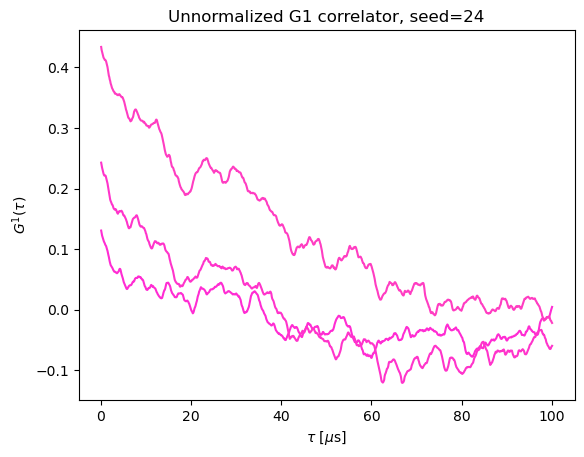

In [4]:
# seeds = [42, 1337, 1729, 724, 333, 137, 31459, 271828, 24, 240]
seed = 24
λrels = LinRange(0.0, 3.0, 30)
# short_list = λrels[1:7]
cm = get_cmap(:spring)
κ=200.0
fb, sb, bases, a, Sx, Sy, Sz = make_operators(4, 100)

for λrel in λrels[6:8]
    tout = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "tout");
    psi_t = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "psi_t");
    W = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "W");


    white_noise = zeros(ComplexF64, length(tout))
    prev_index = 1
    new_index = 1
    for i = 2:length(tout)
        new_index = prev_index
        while W.t[new_index] < tout[i]
            new_index += 1
        end
        white_noise[i] = (W.u[new_index] - W.u[prev_index])/(tout[i] - tout[i-1])
        prev_index = new_index
    end

    Jhet = sqrt(2*κ)*expect(a, psi_t) + conj(white_noise);
    dt = tout[2] - tout[1]
    tau = dt*10
    Jhetfilt = exp_filter(Jhet, tau, dt)
    time_bins = 1000
    time = dt*collect(1:time_bins)

    Background = exp.(-time/tau)/(dt)*(1 - exp(-dt/tau))^2/(1 - exp(-2*dt/tau))

    # plot(time, two_point_correlator(Jhetfilt, tout, dt, time_bins))#  - Background
    # plot(time, Background)
    plot(time, two_point_correlator(Jhetfilt, tout, dt, time_bins) - Background, color=cm(λrel/λrels[end]), label="$(round(λrel,digits=2))")
    # plot(time, two_point_correlator(Jhetfilt, tout, dt, time_bins) - two_point_correlator(exp_filter(conj(white_noise), tau, dt), tout, dt, time_bins))
end
# legend()
xlabel(L"$\tau$ [$\mu$s]")
ylabel(L"$G^1 (\tau)$")
# PyPlot.colorbar()
PyPlot.title("Unnormalized G1 correlator, seed=$(seed)")
PyPlot.display_figs()

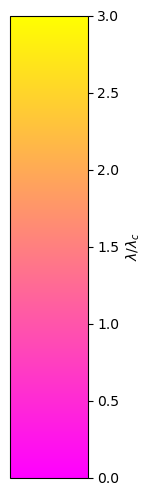

In [25]:
fig, ax = PyPlot.subplots(figsize=(1,6))
cm = get_cmap(:spring)
norm = matplotlib[:colors][:Normalize](vmin=0.0, vmax=3.0)
cb1 = matplotlib[:colorbar][:ColorbarBase](ax, cmap=cm, norm=norm)
cb1.set_label("\$\\lambda/\\lambda_c\$")
PyPlot.display_figs()

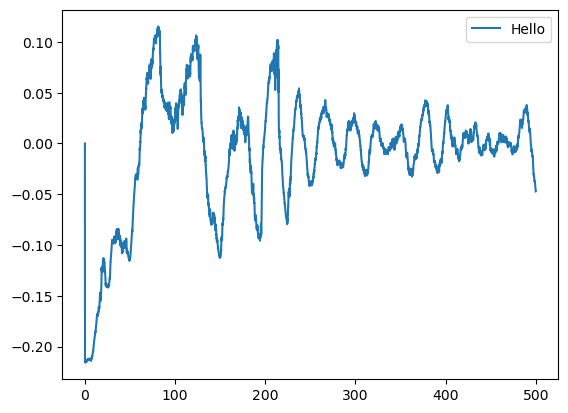

In [53]:
plot(tout, imag.(expect(a, psi_t)), label="Hello")
legend()
PyPlot.display_figs()

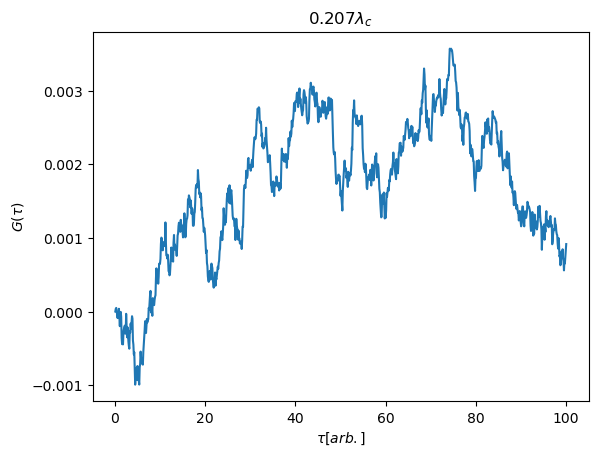

In [27]:
seeds = [42, 1337, 1729, 724, 333, 137, 31459, 271828, 24, 240]
seed = 42
λrel = 0.207
κ=200.0
tout = load("DickeModelRslts4/seed=$(seed)lambda=$(λrel).jld2", "tout");
psi_t = load("DickeModelRslts4/seed=$(seed)lambda=$(λrel).jld2", "psi_t");
W = load("DickeModelRslts4/seed=$(seed)lambda=$(λrel).jld2", "W");

white_noise = zeros(ComplexF64, length(tout))
prev_index = 1
new_index = 1
for i = 2:length(tout)
    new_index = prev_index
    while W.t[new_index] < tout[i]
        new_index += 1
    end
    white_noise[i] = (W.u[new_index] - W.u[prev_index])/(tout[i] - tout[i-1])
    prev_index = new_index
end

Jhet = sqrt(2*κ)*expect(a, psi_t) + conj(white_noise);
dt = tout[2] - tout[1]
tau = dt*1000
time_bins = 1000
time = dt*collect(1:time_bins)

Background = zeros(length(time))
Background[1] = 1/dt

# plot(time, two_point_correlator(Jhet, tout, dt, time_bins))#  - Background
# plot(time, Background)
plot(time, exp_filter(two_point_correlator(Jhet, tout, dt, time_bins) - Background, tau, dt))
# plot(time, two_point_correlator(Jhet, tout, dt, time_bins) - two_point_correlator(conj(white_noise), tout, dt, time_bins))
xlabel(L"\tau [arb.]")
ylabel(L"$G(\tau)$")
PyPlot.title("$(λrel)\$\\lambda_c\$")
PyPlot.display_figs()

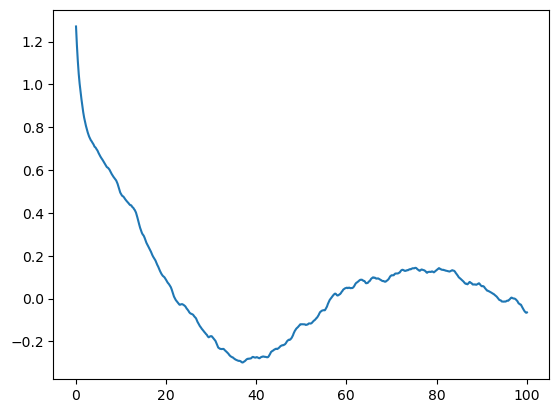

In [23]:
plot(time, two_point_correlator(Jhetfilt, tout, dt, time_bins) - two_point_correlator(exp_filter(conj(white_noise), tau, dt), tout, dt, time_bins))
PyPlot.display_figs()

In [70]:
two_point_correlator(Jhetfilt, tout, dt, 300)[2]

0.5062638157327481 + 0.00455229561347181im

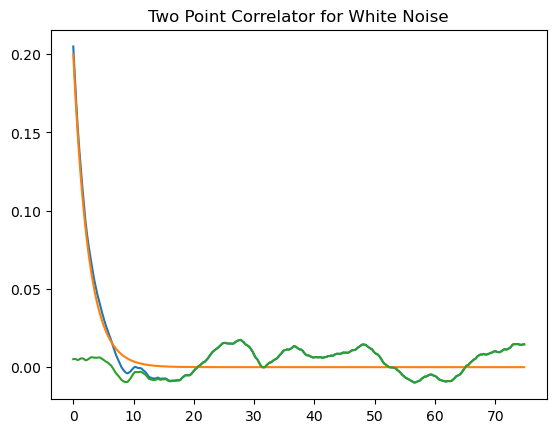

In [148]:
W = WienerProcess(0.,im*0., im*0.)
time_total = LinRange(0.0,1000.0,4000)
time = time_total[1:300]
dt = time[2] - time[1]
tau = 10*dt
noise = make_white_noise(time_total, W)
filt_noise = exp_filter(noise, tau, dt)
Background = exp.(-time/tau)/dt*(1 - exp(-dt/tau))^2/(1 - exp(-2*dt/tau))
Bin_var = 1/dt

# plot(time[1:300], two_point_correlator(noise, time, dt, 300))#  - Background
plot(time, two_point_correlator(filt_noise, time_total, dt, 300))
plot(time, Background)
# plot(time, two_point_correlator(noise, time_total, dt, 300))
# plot(time, Bin_var*ones(length(time)))
plot(time, two_point_correlator(filt_noise, time_total, dt, 300)-Background)
PyPlot.title("Two Point Correlator for White Noise")
PyPlot.display_figs()